# Variational AutoEncoder Fashion MNIST

Note: This notebook is desinged to run with GPU runtime.

Import modules and set random seeds.

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf
#import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(20230629)
tf.random.set_seed(20230629)

Download the Fashion MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
train_images = train_images.reshape((len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

Show sample images for 10 categories.

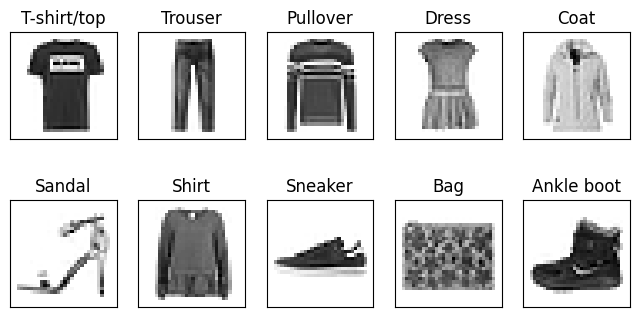

In [3]:
sample_indices = []
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    for c, (image, label) in enumerate(zip(train_images, train_labels)):
        if np.argmax(label) == i:
            sample_indices.append(c)
            break

fig = plt.figure(figsize=(8, 4))
for i in range(10):
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(labels[i])
    subplot.imshow(train_images[sample_indices[i]].reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

Define the encoder with convolutional filters.

In [4]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Reshape((32, 32, 1), input_shape=(32*32,), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 16, 16, 32)        320       
                                                                 
 conv_filter2 (Conv2D)       (None, 8, 8, 64)          18496     
                                                                 
 conv_filter3 (Conv2D)       (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 mean_and_log_var (Dense)    (None, 4)                 8196      
                                                                 
Total params: 100,868
Trainable params: 100,868
Non-trainab

Define the sampler from the normal distribution.

In [5]:
sampler = models.Sequential(name='sampler')
sampler.add(layers.Lambda(
    lambda x: x[:, 0:2] + tf.exp(0.5 * x[:, 2:4]) * tf.random.normal(shape=(tf.shape(x)[0], 2)),
    input_shape=(4,), name='sampled_embedding'))

sampler.summary()

Model: "sampler"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sampled_embedding (Lambda)  (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Define the decoder with transoposed convolutional filters.

In [6]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(4 * 4 * 128, input_shape=(2, ), name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape2'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                        activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand (Dense)              (None, 2048)              6144      
                                                                 
 reshape2 (Reshape)          (None, 4, 4, 128)         0         
                                                                 
 conv_transpose1 (Conv2DTran  (None, 8, 8, 64)         73792     
 spose)                                                          
                                                                 
 conv_transpose2 (Conv2DTran  (None, 16, 16, 32)       18464     
 spose)                                                          
                                                                 
 conv_transpose3 (Conv2DTran  (None, 32, 32, 1)        289       
 spose)                                                          
                                                           

Define Variational AutoEncoder by combining the encoder, the sampler and the decoder.

In [7]:
model_input = tf.keras.Input(shape=(32*32,))
model_output = layers.Concatenate(name='prediction_with_mean_log_var')(
    [encoder(model_input), decoder(sampler(encoder(model_input)))])

model = models.Model(model_input, model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 encoder (Sequential)           (None, 4)            100868      ['input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 sampler (Sequential)           (None, 2)            0           ['encoder[1][0]']                
                                                                                                  
 decoder (Sequential)           (None, 1024)         98689       ['sampler[0][0]']            

Define the custom loss funtion using MSE and the KL divergence.

In [8]:
def custom_loss(y_true, y_pred):
    mean, log_var, pred = y_pred[:, 0:2], y_pred[:, 2:4], y_pred[:, 4:]
    reconstruction_loss = losses.mse(pred, y_true)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.001* kl_loss
    return loss

Compile the model using the Adam optimizer and the custom loss function.

In [9]:
model.compile(optimizer='adam', loss=custom_loss)

Define a function to show reconstructed images.

In [10]:
def show_result():
    results = model.predict(train_images[sample_indices], verbose=0)[:, 4:]

    fig = plt.figure(figsize=(16, 2.7))
    for i in range(10):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(train_images[sample_indices[i]].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

Train the model for a single epoch with 30,000 images, and show the intermediate result.

300/300 [==============================] - 14s 8ms/step - loss: 0.0626


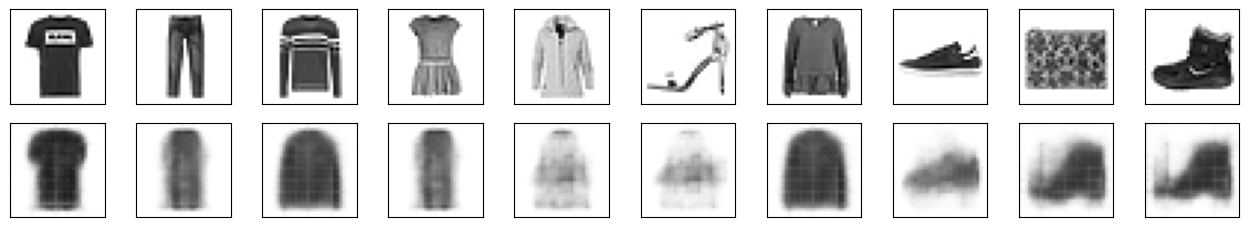

In [11]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=100, epochs=1)
show_result()

Train the model for additional epochs, and show the final result.

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0330
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0310
Epoch 3/50
600/600 [==============================] - 5s 9ms/step - loss: 0.0303
Epoch 4/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0298
Epoch 5/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0294
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0291
Epoch 7/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0289
Epoch 8/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0287
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0286
Epoch 10/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0284
Epoch 11/50
600/600 [==============================] - 4s 6ms/step - loss: 0.0282
Epoch 12/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0282
Epoch 13/50
600/600 [====

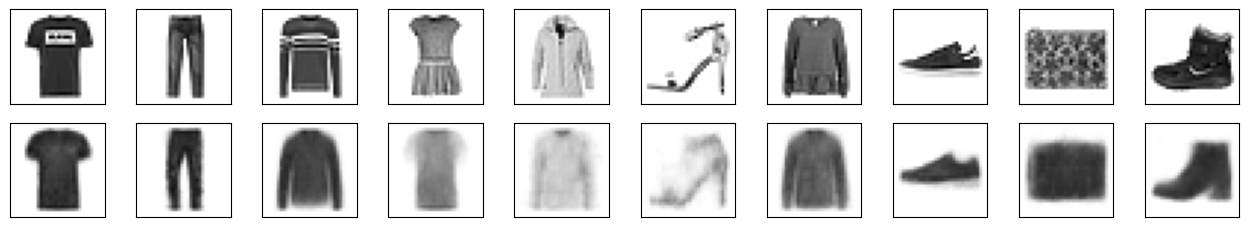

In [12]:
%%time
history = model.fit(train_images, train_images,
                    batch_size=100, epochs=50)
show_result()

Show the embeddings of training data.

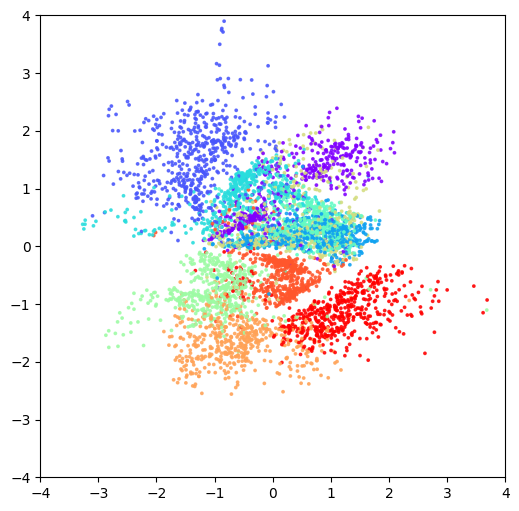

In [13]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstructed images from a circile on the embedding space.

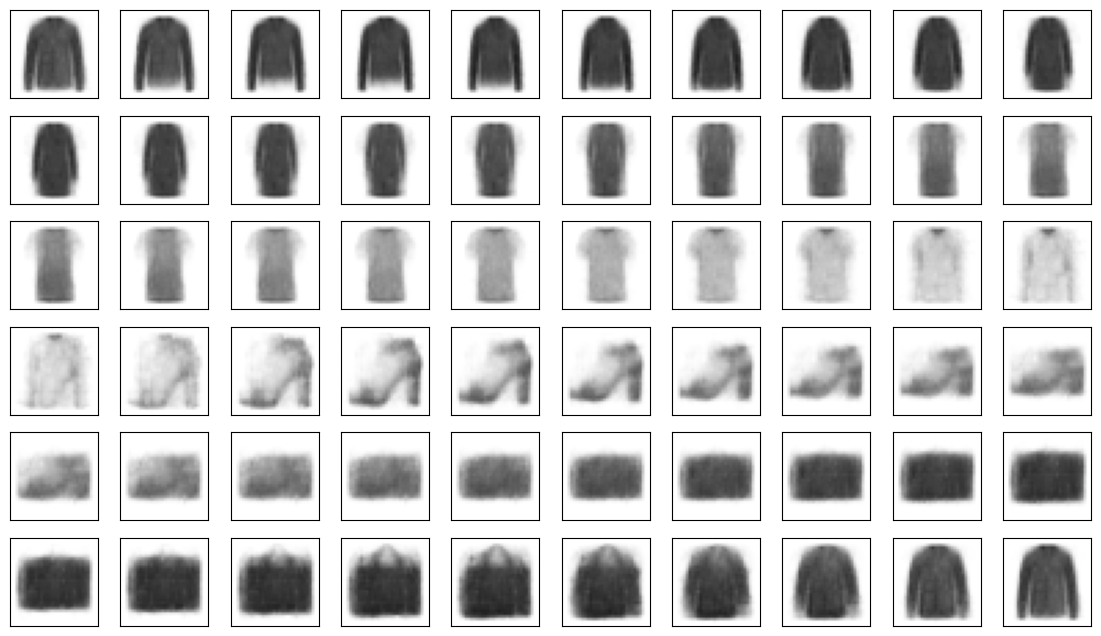

In [14]:
samples = []
for theta in np.linspace(0, 2*np.pi, 60):
    samples.append([0.8*np.cos(theta), 0.8*np.sin(theta)])
reconstructions = decoder.predict(samples, verbose=0)

fig = plt.figure(figsize=(14, 8))
for i in range(60):
    subplot = fig.add_subplot(6, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(reconstructions[i].reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

Show the embeddings of training data over the entire embedding space through a variable conversion with the sigmoid function.

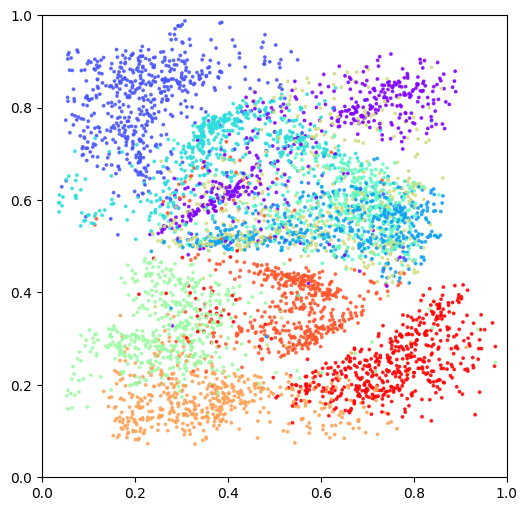

In [15]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0, 1))
subplot.set_ylim((0, 1))
_ = subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstruction images over the entire embedding space.

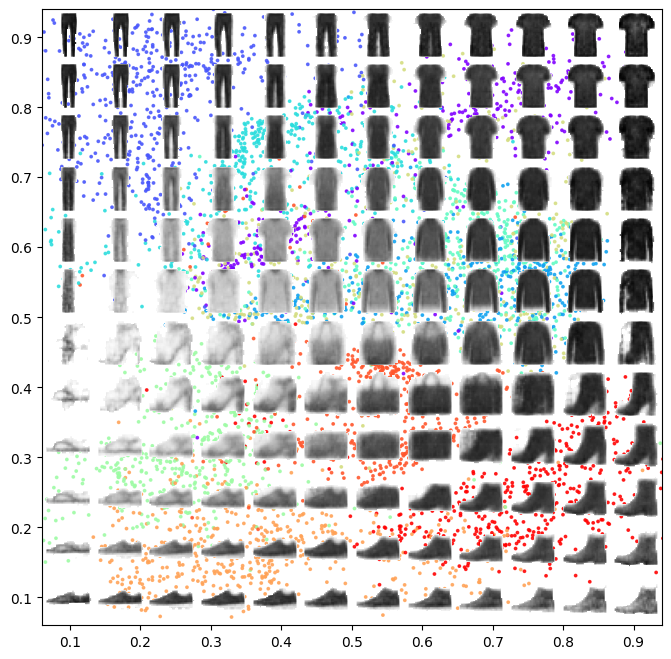

In [16]:
x = np.linspace(0.1, 0.9, 12)
y = np.linspace(0.9, 0.1, 12) # Need inversion
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(logit(xv), logit(yv))))

reconstructions = decoder.predict(grid, verbose=0)

fig = plt.figure(figsize=(8, 8))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0.06, 0.94))
subplot.set_ylim((0.06, 0.94))
subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                cmap='rainbow',
                c=example_labels, alpha=0.8, s=3)
my_cmap = copy.copy(colormaps['gray_r'])
my_cmap.set_bad(alpha=0)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(12*12):
    subplot = fig.add_subplot(12, 12, i + 1)
    subplot.axis('off')
    img = map(lambda x: np.nan if x < 0.02 else x, reconstructions[i])
    subplot.imshow(np.array(list(img)).reshape((32, 32)),
                   vmin=0, vmax=1, cmap=my_cmap)